In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install autogluon --quiet

ERROR: Operation cancelled by user


In [2]:
!pip install timesfm[torch] --quiet

In [3]:
!pip install uni2ts --quiet

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

^C
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache direc

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm, matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [4]:
plt.rc('font', family='NanumBarunGothic')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/DSL/25-2-EDA/data/20082023질병통계.csv')
df.head()

,연도,연령,질병분류,진료형태,진료실인원수,입내원일수,요양급여일수,진료비,급여비,본인부담금,본인부담률,질병분류_22
0,2008,0세,1,계 S.T,4.0,6.0,6.0,238.82,188.126,50.694,0.212269,1
1,2008,0세,1,외래 O.P,4.0,6.0,6.0,238.82,188.126,50.694,0.212269,1
2,2008,0세,1,입원 I.P,0.0,0.0,0.0,0.00,0.000,0.000,0.000000,1
3,2008,0세,2,계 S.T,4.0,5.0,5.0,81.78,57.589,24.191,0.295806,1
4,2008,0세,2,외래 O.P,4.0,5.0,5.0,81.78,57.589,24.191,0.295806,1


In [6]:
df['연도'].unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023])

In [15]:
df_st = df[df['진료형태'] == '계\u3000\u3000S.T']
df_st.head()

In [68]:
df_ip = df[df['진료형태'] == '입원\u3000I.P']
df_ip.head()

,연도,연령,질병분류,진료형태,진료실인원수,입내원일수,요양급여일수,진료비,급여비,본인부담금,본인부담률,질병분류_22
2,2008,0세,1,입원 I.P,0.0,0.0,0.0,0.00,0.00,0.00,0.000000,1
5,2008,0세,2,입원 I.P,0.0,0.0,0.0,0.00,0.00,0.00,0.000000,1
8,2008,0세,3,입원 I.P,1.0,3.0,6.0,241.06,216.96,24.10,0.099975,1
11,2008,0세,4,입원 I.P,8.0,36.0,36.0,2144.85,1916.83,228.02,0.106310,1
14,2008,0세,5,입원 I.P,6778.0,37947.0,65881.0,3529643.55,3182367.54,347276.01,0.098388,1


In [70]:
def preprocess_ts(df: pd.DataFrame):
    ts = df.groupby('연도')['급여비'].sum()
    ts.index = pd.to_datetime(ts.index, format='%Y')
    ts = ts.reset_index(drop=False)
    ts = ts.rename(columns={'연도': 'timestamp', '급여비': 'target'})
    ts['item_id'] = ['T0'] * len(ts)
    ts = ts.set_index(['item_id', 'timestamp'])
    return ts

In [71]:
ts_st = preprocess_ts(df_st)
ts_st.head()

target
item_id timestamp               
T0      2008-01-01  2.455979e+10
        2009-01-01  2.750061e+10
        2010-01-01  3.058757e+10
        2011-01-01  3.255991e+10
        2012-01-01  3.415841e+10

In [72]:
ts_ip = preprocess_ts(df_ip)
ts_ip.head()

target
item_id timestamp               
T0      2008-01-01  8.916474e+09
        2009-01-01  1.007675e+10
        2010-01-01  1.163320e+10
        2011-01-01  1.254086e+10
        2012-01-01  1.353209e+10

In [21]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

ts_df = TimeSeriesDataFrame(ts_yearly_nhis)

predictor = TimeSeriesPredictor(prediction_length=5, quantile_levels=[0.05, 0.95]).fit(
    ts_df,
    hyperparameters={"Chronos": [
        #{"model_path": "amazon/chronos-bolt-base"},
        #{"model_path": "amazon/chronos-t5-base"},
        #{"model_path": "amazon/chronos-t5-small"},
        {"model_path": "amazon/chronos-t5-tiny"},
    ]},
    num_val_windows=2,
    random_seed=42,
)

predictions = predictor.predict(ts_df[:-1])

ModuleNotFoundError: No module named 'autogluon'

In [64]:
predictions = predictions.rename(columns={'0.05': '평균_ci_하한', '0.95': '평균_ci_상한', 'mean': '평균'})
predictions = predictions.reset_index('item_id', drop=True)
predictions

향후 5년 예측:


평균      평균_ci_하한      평균_ci_상한
item_id timestamp                                           
T0      2023-01-01  7.391333e+10  7.004557e+10  7.999356e+10
        2024-01-01  7.417555e+10  6.650561e+10  8.284520e+10
        2025-01-01  7.432305e+10  6.552228e+10  8.340242e+10
        2026-01-01  7.333972e+10  5.958955e+10  8.917127e+10
        2027-01-01  7.255305e+10  5.436153e+10  8.963015e+10

In [73]:
def interpolate_to_multiple(df_one_series: pd.DataFrame,
                            multiple: int = 64 + 32) -> pd.DataFrame:
    df = df_one_series.sort_values("ds").reset_index(drop=True)
    uid = df["unique_id"].iat[0]

    n_orig = len(df)
    if n_orig % multiple == 0:
        return df

    new_len = ((n_orig + multiple - 1) // multiple) * multiple
    t_numeric = df["ds"].view("int64").to_numpy()
    y_numeric = df["y"].to_numpy()

    new_t = np.linspace(t_numeric[0], t_numeric[-1], new_len, dtype=np.int64)
    new_y = np.interp(new_t, t_numeric, y_numeric)

    df_interp = pd.DataFrame({
        "unique_id": uid,
        "ds": pd.to_datetime(new_t),
        "y": new_y
    })

    return df_interp

In [75]:
import timesfm

df_tf_st = (
    ts_st.reset_index(drop=False)
         .rename(columns={"item_id": "unique_id", "timestamp": "ds", "target": "y"})
         .sort_values(["unique_id", "ds"])
)

df_tf_ip = (
    ts_ip.reset_index(drop=False)
         .rename(columns={"item_id": "unique_id", "timestamp": "ds", "target": "y"})
         .sort_values(["unique_id", "ds"])
)

model = timesfm.TimesFm(
    hparams=timesfm.TimesFmHparams(
        backend="cpu",
        horizon_len=72,
        context_len=64 + 32,
        per_core_batch_size=1,
        num_layers=50,
        #input_patch_len=4,
    ),
    checkpoint=timesfm.TimesFmCheckpoint(
        huggingface_repo_id="google/timesfm-2.0-500m-pytorch"
    )
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [76]:
predictions_st = model.forecast_on_df(
    inputs=interpolate_to_multiple(df_tf_st),
    freq="ME",
    value_name="y",
    num_jobs=-1,
)

predictions_st = predictions_st.drop(columns=['timesfm-q-0.2', 'timesfm-q-0.3', 'timesfm-q-0.4', 'timesfm-q-0.5', 'timesfm-q-0.6', 'timesfm-q-0.7', 'timesfm-q-0.8'])

predictions_st.head()

Processing dataframe with multiple processes.


/tmp/ipython-input-591606231.py:11: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  t_numeric = df["ds"].view("int64").to_numpy()


Finished preprocessing dataframe.
Finished forecasting.


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.9
0,T0,2023-01-31,7.246732e+10,6.940262e+10,7.550015e+10
1,T0,2023-02-28,7.308753e+10,6.926086e+10,7.690505e+10
2,T0,2023-03-31,7.369879e+10,6.942387e+10,7.825521e+10
3,T0,2023-04-30,7.401824e+10,6.920642e+10,7.930397e+10
4,T0,2023-05-31,7.451252e+10,6.918661e+10,8.038717e+10


In [77]:
predictions_st.shape

(72, 5)

In [78]:
predictions_st = predictions_st[23::12]
predictions_st.loc[:, 'ds'] = predictions_st['ds'].dt.year
predictions_st

/tmp/ipython-input-1355375594.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2024 2025 2026 2027 2028]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  predictions_st.loc[:, 'ds'] = predictions_st['ds'].dt.year


,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.9
23,T0,2024,8.181959e+10,7.269387e+10,9.262368e+10
35,T0,2025,8.390227e+10,7.399150e+10,9.572187e+10
47,T0,2026,8.574251e+10,7.531767e+10,9.858669e+10
59,T0,2027,8.934634e+10,7.837317e+10,1.044230e+11
71,T0,2028,9.503669e+10,8.355765e+10,1.119046e+11


In [46]:
predictions_st = (
    predictions_st
        .set_index('ds')
        .drop(columns='unique_id')
        .rename(columns={'timesfm': 'target', 'timesfm-q-0.9': '평균_ci_상한', 'timesfm-q-0.1': '평균_ci_하한'})
)
predictions_st.index = pd.to_datetime(predictions_st.index, format='%Y')
predictions_st

,평균,평균_ci_하한,평균_ci_상한
ds,,,
2024-01-01,8.181959e+10,7.269387e+10,9.262368e+10
2025-01-01,8.390227e+10,7.399150e+10,9.572187e+10
2026-01-01,8.574251e+10,7.531767e+10,9.858669e+10
2027-01-01,8.934634e+10,7.837317e+10,1.044230e+11
2028-01-01,9.503669e+10,8.355765e+10,1.119046e+11


In [13]:
from gluonts.dataset.pandas import PandasDataset
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule

wide = (
    ts_yearly_nhis
        .reset_index(drop=False)
        .pivot(index="timestamp", columns="item_id", values="target")
        .sort_index()
)
dataset = PandasDataset(dict(wide))

model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained("Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=5,
    context_length=len(wide),
    patch_size=2,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=dataset.num_feat_dynamic_real,
    past_feat_dynamic_real_dim=dataset.num_past_feat_dynamic_real,
)

predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(dataset, num_samples=100)

# 첫 번째 forecast 예시
f = next(iter(forecasts))
print("Point forecast (mean):", f.mean)

RuntimeError: operator torchvision::nms does not exist

In [47]:
ts_yearly_nhis = ts_yearly_nhis.reset_index('item_id', drop=True)
ts_yearly_nhis.head()

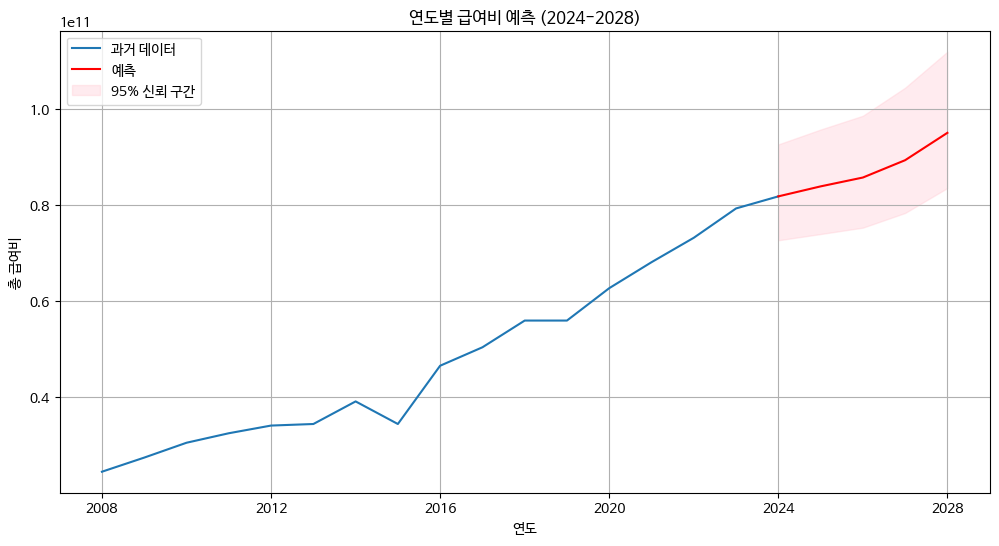

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(pd.concat([ts_yearly_nhis, predictions['target'][:1]]).index, pd.concat([ts_yearly_nhis, predictions['target'][:1]]), label='과거 데이터')

plt.plot(predictions['target'].index,
         predictions['target'].values, color='red', label='예측')

plt.fill_between(predictions.index,
                 predictions['평균_ci_하한'],
                 predictions['평균_ci_상한'],
                 color='pink', alpha=0.3, label='95% 신뢰 구간')

plt.title('연도별 급여비 예측 (2024-2028)')
plt.xlabel('연도')
plt.ylabel('총 급여비')
plt.legend()
plt.grid(True)
plt.show()

## 예측 분석 및 해석


In [65]:
print("\n향후 5년 예측 급여비(천 원) 값 (2024-2028):")
display(predictions)
print(f"2024년 예상 총 급여비(천 원): {predictions['target'].iloc[0]:,.0f}")
print(f"2028년 예상 총 급여비(천 원): {predictions['target'].iloc[-1]:,.0f}")


향후 5년 예측 급여비(천 원) 값 (2024-2028):


,target,평균_ci_하한,평균_ci_상한
ds,,,
2024-01-01,8.181959e+10,7.269387e+10,9.262368e+10
2025-01-01,8.390227e+10,7.399150e+10,9.572187e+10
2026-01-01,8.574251e+10,7.531767e+10,9.858669e+10
2027-01-01,8.934634e+10,7.837317e+10,1.044230e+11
2028-01-01,9.503669e+10,8.355765e+10,1.119046e+11


2024년 예상 총 급여비(천 원): 81,819,590,656
2028년 예상 총 급여비(천 원): 95,036,694,528


## 22대 질병 분류별 급여비 예측



In [66]:
df_st.head()

,연도,연령,질병분류,진료형태,진료실인원수,입내원일수,요양급여일수,진료비,급여비,본인부담금,본인부담률,질병분류_22
0,2008,0세,1,계 S.T,4.0,6.0,6.0,238.82,188.126,50.694,0.212269,1
3,2008,0세,2,계 S.T,4.0,5.0,5.0,81.78,57.589,24.191,0.295806,1
6,2008,0세,3,계 S.T,66.0,121.0,124.0,2591.22,2055.269,535.951,0.206833,1
9,2008,0세,4,계 S.T,32.0,124.0,124.0,3916.18,3212.295,703.885,0.179738,1
12,2008,0세,5,계 S.T,94595.0,272106.0,311478.0,8146275.89,6513660.003,1632615.887,0.200413,1


In [67]:
# 22대 질병분류별 연도별 총 급여비 집계
질병분류별_연도별_급여비 = df_st.groupby(['질병분류_22', '연도'])['급여비'].sum().reset_index()

# 각 질병 분류별 시계열 데이터와 모델 저장
질병분류별_예측_모델 = {}
질병분류별_예측_결과 = {}

# 각 질병 분류별로 반복하여 ARIMA 모델 적합 및 예측 수행
for 질병분류 in 질병분류별_연도별_급여비['질병분류_22'].unique():
    print(f"\n--- 질병분류 {질병분류} 분석 ---")
    # 특정 질병 분류의 시계열 데이터 추출
    ts_질병 = 질병분류별_연도별_급여비[질병분류별_연도별_급여비['질병분류_22'] == 질병분류].set_index('연도')['급여비']

    # 데이터가 충분한지 확인 (최소한 ARIMA 모델 적합에 필요한 데이터 수 이상)
    if len(ts_질병) < 6: # 예: ARIMA(2,1,2)에 필요한 최소 데이터 수
        print(f"질병분류 {질병분류}: 데이터 포인트 부족 ({len(ts_질병)}개). 예측 건너뛰기.")
        continue

    # 시계열 데이터의 인덱스를 PeriodIndex로 변환 (예측을 위해 필요)
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")

    # 최적의 ARIMA 차수 탐색 (AIC 기준)
    p_values = range(0, 3)
    d_values = range(0, 2) # 차분은 0 또는 1
    q_values = range(0, 3)

    최적_AIC = np.inf
    최적_차수 = None

    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model = ARIMA(ts_질병, order=order)
            model_fit = model.fit()
            if model_fit.aic < 최적_AIC:
                최적_AIC = model_fit.aic
                최적_차수 = order
            # print(f'ARIMA{order} AIC={model_fit.aic:.2f}') # 탐색 과정 출력이 많으므로 주석 처리
        except Exception as e:
            # print(f'ARIMA{order} failed: {e}') # 실패 출력도 많으므로 주석 처리
            continue

    if 최적_차수:
        print(f"질병분류 {질병분류} 최적 ARIMA 차수: {최적_차수} (AIC: {최적_AIC:.2f})")
        try:
            # 최적 차수로 ARIMA 모델 적합
            model = ARIMA(ts_질병, order=최적_차수)
            model_fit = model.fit()
            질병분류별_예측_모델[질병분류] = model_fit

            # 향후 5년 예측
            forecast_steps = 5
            예측_객체 = model_fit.get_forecast(steps=forecast_steps)
            예측_df = 예측_객체.conf_int(alpha=0.05)
            예측_df['평균'] = 예측_객체.predicted_mean

            # 예측 결과 DataFrame 컬럼명 변경
            예측_df.columns = ['평균_ci_하한', '평균_ci_상한', '평균']

            # 예측 결과 저장
            질병분류별_예측_결과[질병분류] = 예측_df

        except Exception as e:
            print(f"질병분류 {질병분류} 최적 차수 {최적_차수} 모델 적합/예측 실패: {e}")
    else:
        print(f"질병분류 {질병분류}: 적합한 ARIMA 모델 차수를 찾지 못했습니다.")

print("\n모든 질병 분류에 대한 ARIMA 모델 적합 및 예측 완료.")


--- 질병분류 1 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/sta

질병분류 1 최적 ARIMA 차수: (0, 1, 0) (AIC: 610.89)

--- 질병분류 2 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

질병분류 2 최적 ARIMA 차수: (1, 1, 2) (AIC: 650.95)

--- 질병분류 3 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11

질병분류 3 최적 ARIMA 차수: (1, 1, 1) (AIC: 559.36)

--- 질병분류 4 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

질병분류 4 최적 ARIMA 차수: (2, 1, 2) (AIC: 631.14)

--- 질병분류 5 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 5 최적 ARIMA 차수: (2, 1, 2) (AIC: 621.89)

--- 질병분류 6 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels

질병분류 6 최적 ARIMA 차수: (1, 1, 2) (AIC: 619.17)

--- 질병분류 7 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 7 최적 ARIMA 차수: (1, 1, 1) (AIC: 619.74)

--- 질병분류 8 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

질병분류 8 최적 ARIMA 차수: (0, 1, 0) (AIC: 573.25)

--- 질병분류 9 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 9 최적 ARIMA 차수: (2, 1, 2) (AIC: 652.58)

--- 질병분류 10 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11

질병분류 10 최적 ARIMA 차수: (0, 1, 0) (AIC: 662.66)

--- 질병분류 11 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 11 최적 ARIMA 차수: (1, 1, 2) (AIC: 650.11)

--- 질병분류 12 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels

질병분류 12 최적 ARIMA 차수: (1, 1, 2) (AIC: 590.74)

--- 질병분류 13 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 13 최적 ARIMA 차수: (2, 1, 2) (AIC: 641.51)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



--- 질병분류 14 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11

질병분류 14 최적 ARIMA 차수: (1, 1, 1) (AIC: 632.43)

--- 질병분류 15 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st

질병분류 15 최적 ARIMA 차수: (2, 1, 2) (AIC: 563.47)

--- 질병분류 16 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st

질병분류 16 최적 ARIMA 차수: (1, 1, 2) (AIC: 566.86)

--- 질병분류 17 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st

질병분류 17 최적 ARIMA 차수: (1, 1, 2) (AIC: 555.54)

--- 질병분류 18 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st

질병분류 18 최적 ARIMA 차수: (1, 1, 1) (AIC: 606.71)

--- 질병분류 19 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

질병분류 19 최적 ARIMA 차수: (1, 1, 1) (AIC: 618.76)

--- 질병분류 21 분석 ---


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


질병분류 21 최적 ARIMA 차수: (0, 1, 0) (AIC: 629.98)

모든 질병 분류에 대한 ARIMA 모델 적합 및 예측 완료.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


## 질병 분류별 예측 결과 시각화

각 22대 질병 분류별로 과거 급여비 데이터와 예측된 미래 값을 신뢰 구간과 함께 시각화

In [ ]:
질병분류별_연도별_급여비.head()

In [ ]:
# 질병 분류별 예측 결과 시각화
for 질병분류, 예측_df in 질병분류별_예측_결과.items():
    print(f"\n--- 질병분류 {질병분류} 예측 시각화 ---")

    # 해당 질병 분류의 과거 시계열 데이터 추출
    ts_질병 = 질병분류별_연도별_급여비[질병분류별_연도별_급여비['질병분류_22'] == 질병분류].set_index('연도')['급여비']
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")


    plt.figure(figsize=(12, 6))
    # 과거 데이터 시각화 (PeriodIndex를 timestamp로 변환)
    plt.plot(ts_질병.index.to_timestamp(), ts_질병, label='과거 데이터')

    # Plot the historical data and the forecast, ensuring the last historical point connects to the first forecast point
    plt.plot(pd.concat([ts_질병[-1:], 예측_df['평균']]).index.to_timestamp(),
             pd.concat([ts_질병[-1:], 예측_df['평균']]).values, color='red', label='예측')

    # 신뢰 구간 시각화 (PeriodIndex를 timestamp로 변환)
    plt.fill_between(예측_df.index.to_timestamp(),
                     예측_df['평균_ci_하한'],
                     예측_df['평균_ci_상한'],
                     color='pink', alpha=0.3, label='95% 신뢰 구간')

    plt.title(f'질병분류 {질병분류} 연도별 급여비 예측 (2024-2028)')
    plt.xlabel('연도')
    plt.ylabel('총 급여비')
    plt.legend()
    plt.grid(True)
    plt.show()

I understand your confusion. The red line starts from the last point of the historical data (2023) and extends to the future (2024-2028) to show a continuous trend from the known data into the predicted period. The ARIMA model uses the historical data up to 2023 to make predictions for 2024 and beyond. The pink shaded area represents the 95% confidence interval for the future predicted values, starting from 2024. So, while the red line visually connects the last historical point to the forecast, the actual prediction starts from 2024, and the confidence interval is shown for that predicted period.



## 질병 분류별 예측 결과 분석 및 해석

In [ ]:
print("===== 질병 분류별 예측 결과 분석 =====")

# 예측 결과 요약 DataFrame 생성
disease_forecast_summary = pd.DataFrame()

for 질병분류, 예측_df in 질병분류별_예측_결과.items():
    # 예측 시작 연도 (2024년)의 예측값
    forecast_2024 = 예측_df.loc[pd.Period(2024, freq='Y'), '평균']
    # 예측 마지막 연도 (2028년)의 예측값
    forecast_2028 = 예측_df.loc[pd.Period(2028, freq='Y'), '평균']
    # 5년간의 예측 증가액
    forecast_increase = forecast_2028 - forecast_2024
    # 5년간의 예측 증가율
    forecast_growth_rate = (forecast_increase / forecast_2024) * 100 if forecast_2024 != 0 else 0

    # 결과 저장
    disease_forecast_summary.loc[질병분류, '2024년 예측 급여비'] = forecast_2024
    disease_forecast_summary.loc[질병분류, '2028년 예측 급여비'] = forecast_2028
    disease_forecast_summary.loc[질병분류, '5년 예측 급여비 증가액'] = forecast_increase
    disease_forecast_summary.loc[질병분류, '5년 예측 증가율 (%)'] = forecast_growth_rate

# 증가액 기준으로 정렬하여 상위 질병 분류 확인
disease_forecast_summary_sorted_increase = disease_forecast_summary.sort_values('5년 예측 급여비 증가액', ascending=False)

print("\n5년 예측 급여비 증가액 기준 질병 분류별 요약 (상위):")
display(disease_forecast_summary_sorted_increase.head())

# 증가율 기준으로 정렬하여 상위 질병 분류 확인
disease_forecast_summary_sorted_growth = disease_forecast_summary.sort_values('5년 예측 증가율 (%)', ascending=False)

print("\n5년 예측 급여비 증가율 기준 질병 분류별 요약 (상위):")
display(disease_forecast_summary_sorted_growth.head())

# 상위 증가액 질병 분류에 대한 해석
top_increase_diseases = disease_forecast_summary_sorted_increase.head(7).index.tolist()
print(f"\n향후 5년간 예측 급여비 증가액이 가장 높은 질병 분류: {top_increase_diseases}")

# 상위 증가율 질병 분류에 대한 해석
top_growth_diseases = disease_forecast_summary_sorted_growth.head(7).index.tolist()
print(f"\n향후 5년간 예측 급여비 증가율이 가장 높은 질병 분류: {top_growth_diseases}")

In [ ]:
print(f"22대 질병분류-2번의 2024년 예상 급여비(천 원): {disease_forecast_summary.loc[2, '2024년 예측 급여비']:,.0f}")
print(f"22대 질병분류-2번의 2028년 예상 급여비(천 원): {disease_forecast_summary.loc[2, '2028년 예측 급여비']:,.0f}")

print(f"\n22대 질병분류-11번의 2024년 예상 급여비(천 원): {disease_forecast_summary.loc[11, '2024년 예측 급여비']:,.0f}")
print(f"22대 질병분류-11번의 2028년 예상 급여비(천 원): {disease_forecast_summary.loc[11, '2028년 예측 급여비']:,.0f}")

급여비 예측 증가액&예측 증가율도 높은 질병(22대): 2번, 11번

## 22대 질병분류 중 2번..


In [ ]:
# 질병분류_22가 2인 데이터만 필터링
df_disease_2 = df_st[df_st['질병분류_22'] == 2].copy()

# 세부 질병별 연도별 총 급여 집계
disease_2_yearly_cost = df_disease_2.groupby(['질병분류', '연도'])['급여비'].sum().reset_index()

display(disease_2_yearly_cost.head())

In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import pandas as pd

# 각 질병 분류별 시계열 데이터와 모델 저장
질병분류별_예측_모델 = {}
질병분류별_예측_결과 = {}

# 각 질병 분류별로 반복하여 ARIMA 모델 적합 및 예측 수행
for 질병분류 in disease_2_yearly_cost['질병분류'].unique():
    print(f"\n--- 질병분류 {질병분류} 분석 ---")
    # 특정 질병 분류의 시계열 데이터 추출
    ts_질병 = disease_2_yearly_cost[disease_2_yearly_cost['질병분류'] == 질병분류].set_index('연도')['급여비']

    # 데이터가 충분한지 확인 (최소한 ARIMA 모델 적합에 필요한 데이터 수 이상)
    if len(ts_질병) < 6: # 예: ARIMA(2,1,2)에 필요한 최소 데이터 수
        print(f"질병분류 {질병분류}: 데이터 포인트 부족 ({len(ts_질병)}개). 예측 건너뛰기.")
        continue

    # 시계열 데이터의 인덱스를 PeriodIndex로 변환 (예측을 위해 필요)
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")

    # 최적의 ARIMA 차수 탐색 (AIC 기준)
    p_values = range(0, 3)
    d_values = range(0, 2) # 차분은 0 또는 1
    q_values = range(0, 3)

    최적_AIC = np.inf
    최적_차수 = None

    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model = ARIMA(ts_질병, order=order)
            model_fit = model.fit()
            if model_fit.aic < 최적_AIC:
                최적_AIC = model_fit.aic
                최적_차수 = order
            # print(f'ARIMA{order} AIC={model_fit.aic:.2f}') # 탐색 과정 출력이 많으므로 주석 처리
        except Exception as e:
            # print(f'ARIMA{order} failed: {e}') # 실패 출력도 많으므로 주석 처리
            continue

    if 최적_차수:
        print(f"질병분류 {질병분류} 최적 ARIMA 차수: {최적_차수} (AIC: {최적_AIC:.2f})")
        try:
            # 최적 차수로 ARIMA 모델 적합
            model = ARIMA(ts_질병, order=최적_차수)
            model_fit = model.fit()
            질병분류별_예측_모델[질병분류] = model_fit

            # 향후 5년 예측
            forecast_steps = 5
            예측_객체 = model_fit.get_forecast(steps=forecast_steps)
            예측_df = 예측_객체.conf_int(alpha=0.05)
            예측_df['평균'] = 예측_객체.predicted_mean

            # 예측 결과 DataFrame 컬럼명 변경
            예측_df.columns = ['평균_ci_하한', '평균_ci_상한', '평균']

            # 예측 결과 저장
            질병분류별_예측_결과[질병분류] = 예측_df

        except Exception as e:
            print(f"질병분류 {질병분류} 최적 차수 {최적_차수} 모델 적합/예측 실패: {e}")
    else:
        print(f"질병분류 {질병분류}: 적합한 ARIMA 모델 차수를 찾지 못했습니다.")

print("\n모든 질병 분류에 대한 ARIMA 모델 적합 및 예측 완료.")

In [ ]:
# 질병 분류별 예측 결과 시각화
for 질병분류, 예측_df in 질병분류별_예측_결과.items():
    print(f"\n--- 질병분류 {질병분류} 예측 시각화 ---")

    # 해당 질병 분류의 과거 시계열 데이터 추출
    ts_질병 = disease_2_yearly_cost[disease_2_yearly_cost['질병분류'] == 질병분류].set_index('연도')['급여비']
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")


    plt.figure(figsize=(12, 6))
    # 과거 데이터 시각화 (PeriodIndex를 timestamp로 변환)
    plt.plot(ts_질병.index.to_timestamp(), ts_질병, label='과거 데이터')
    # 예측 데이터 시각화 (PeriodIndex를 timestamp로 변환)
    plt.plot(예측_df.index.to_timestamp(), 예측_df['평균'], color='red', label='예측')
    # 신뢰 구간 시각화 (PeriodIndex를 timestamp로 변환)
    plt.fill_between(예측_df.index.to_timestamp(),
                     예측_df['평균_ci_하한'],
                     예측_df['평균_ci_상한'],
                     color='pink', alpha=0.3, label='95% 신뢰 구간')

    plt.title(f'질병분류 {질병분류} 연도별 급여비 예측 (2024-2028)')
    plt.xlabel('연도')
    plt.ylabel('총 급여비')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print("===== 질병분류 2 내 세부 질병별 예측 결과 분석 =====")

# 예측 결과 요약 DataFrame 생성
disease_2_forecast_summary = pd.DataFrame()

for 질병분류, 예측_df in 질병분류별_예측_결과.items():
    # 예측 시작 연도 (2024년)의 예측값
    forecast_2024 = 예측_df.loc[pd.Period(2024, freq='Y'), '평균']
    # 예측 마지막 연도 (2028년)의 예측값
    forecast_2028 = 예측_df.loc[pd.Period(2028, freq='Y'), '평균']
    # 5년간의 예측 증가액
    forecast_increase = forecast_2028 - forecast_2024
    # 5년간의 예측 증가율
    forecast_growth_rate = (forecast_increase / forecast_2024) * 100 if forecast_2024 != 0 else 0

    # 결과 저장
    disease_2_forecast_summary.loc[질병분류, '2024년 예측 급여비'] = forecast_2024
    disease_2_forecast_summary.loc[질병분류, '2028년 예측 급여비'] = forecast_2028
    disease_2_forecast_summary.loc[질병분류, '5년 예측 급여비 증가액'] = forecast_increase
    disease_2_forecast_summary.loc[질병분류, '5년 예측 증가율 (%)'] = forecast_growth_rate

# 증가액 기준으로 정렬하여 상위 질병 분류 확인
disease_2_forecast_summary_sorted_increase = disease_2_forecast_summary.sort_values('5년 예측 급여비 증가액', ascending=False)

print("\n5년 예측 급여비 증가액 기준 질병분류 2 내 세부 질병별 요약 (상위):")
display(disease_2_forecast_summary_sorted_increase.head())

# 증가율 기준으로 정렬하여 상위 질병 분류 확인
disease_2_forecast_summary_sorted_growth = disease_2_forecast_summary.sort_values('5년 예측 증가율 (%)', ascending=False)

print("\n5년 예측 급여비 증가율 기준 질병분류 2 내 세부 질병별 요약 (상위):")
display(disease_2_forecast_summary_sorted_growth.head())

# 상위 증가액 질병 분류에 대한 해석
top_increase_diseases_2 = disease_2_forecast_summary_sorted_increase.head(5).index.tolist()
print(f"\n질병분류 2 내에서 향후 5년간 예측 급여비 증가액이 가장 높은 세부 질병: {top_increase_diseases_2}")

# 상위 증가율 질병 분류에 대한 해석
top_growth_diseases_2 = disease_2_forecast_summary_sorted_growth.head(5).index.tolist()
print(f"\n질병분류 2 내에서 향후 5년간 예측 급여비 증가율이 가장 높은 세부 질병: {top_growth_diseases_2}")

In [ ]:
print(f"298 질병분류-73번의 2024년 예상 급여비(천 원): {disease_2_forecast_summary.loc[73, '2024년 예측 급여비']:,.0f}")
print(f"298 질병분류-73의 2028년 예상 급여비(천 원): {disease_2_forecast_summary.loc[73, '2028년 예측 급여비']:,.0f}")

print(f"\n298 질병분류-77의 2024년 예상 급여비(천 원): {disease_2_forecast_summary.loc[77, '2024년 예측 급여비']:,.0f}")
print(f"298 질병분류-77의 2028년 예상 급여비(천 원): {disease_2_forecast_summary.loc[77, '2028년 예측 급여비']:,.0f}")

##질병분류 22대 중 11번..

In [ ]:
# 질병분류_22가 11인 데이터만 필터링
df_disease_11 = df_st[df_st['질병분류_22'] == 11].copy()

# 세부 질병별 연도별 총 급여 집계
disease_11_yearly_cost = df_disease_11.groupby(['질병분류', '연도'])['급여비'].sum().reset_index()

display(disease_11_yearly_cost.head())

In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import pandas as pd

# 각 질병 분류별 시계열 데이터와 모델 저장
disease_11_forecast_models = {}
disease_11_forecast_results = {}

# 각 세부 질병별로 반복하여 ARIMA 모델 적합 및 예측 수행
for 질병분류 in disease_11_yearly_cost['질병분류'].unique():
    print(f"\n--- 질병분류 {질병분류} 분석 ---")
    # 특정 질병 분류의 시계열 데이터 추출
    ts_질병 = disease_11_yearly_cost[disease_11_yearly_cost['질병분류'] == 질병분류].set_index('연도')['급여비']

    # 데이터가 충분한지 확인 (최소한 ARIMA 모델 적합에 필요한 데이터 수 이상)
    if len(ts_질병) < 6: # 예: ARIMA(2,1,2)에 필요한 최소 데이터 수
        print(f"질병분류 {질병분류}: 데이터 포인트 부족 ({len(ts_질병)}개). 예측 건너뛰기.")
        continue

    # 시계열 데이터의 인덱스를 PeriodIndex로 변환 (예측을 위해 필요)
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")

    # 최적의 ARIMA 차수 탐색 (AIC 기준)
    p_values = range(0, 3)
    d_values = range(0, 2) # 차분은 0 또는 1
    q_values = range(0, 3)

    최적_AIC = np.inf
    최적_차수 = None

    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model = ARIMA(ts_질병, order=order)
            model_fit = model.fit()
            if model_fit.aic < 최적_AIC:
                최적_AIC = model_fit.aic
                최적_차수 = order
            # print(f'ARIMA{order} AIC={model_fit.aic:.2f}') # 탐색 과정 출력이 많으므로 주석 처리
        except Exception as e:
            # print(f'ARIMA{order} failed: {e}') # 실패 출력도 많으므로 주석 처리
            continue

    if 최적_차수:
        print(f"질병분류 {질병분류} 최적 ARIMA 차수: {최적_차수} (AIC: {최적_AIC:.2f})")
        try:
            # 최적 차수로 ARIMA 모델 적합
            model = ARIMA(ts_질병, order=최적_차수)
            model_fit = model.fit()
            disease_11_forecast_models[질병분류] = model_fit

            # 향후 5년 예측
            forecast_steps = 5
            예측_객체 = model_fit.get_forecast(steps=forecast_steps)
            예측_df = 예측_객체.conf_int(alpha=0.05)
            예측_df['평균'] = 예측_객체.predicted_mean

            # 예측 결과 DataFrame 컬럼명 변경
            예측_df.columns = ['평균_ci_하한', '평균_ci_상한', '평균']

            # 예측 결과 저장
            disease_11_forecast_results[질병분류] = 예측_df

        except Exception as e:
            print(f"질병분류 {질병분류} 최적 차수 {최적_차수} 모델 적합/예측 실패: {e}")
    else:
        print(f"질병분류 {질병분류}: 적합한 ARIMA 모델 차수를 찾지 못했습니다.")

print("\n질병분류 11 내 모든 세부 질병에 대한 ARIMA 모델 적합 및 예측 완료.")

In [ ]:
# 질병 분류별 예측 결과 시각화
for 질병분류, 예측_df in disease_11_forecast_results.items():
    print(f"\n--- 질병분류 {질병분류} 예측 시각화 ---")

    # 해당 질병 분류의 과거 시계열 데이터 추출
    ts_질병 = disease_11_yearly_cost[disease_11_yearly_cost['질병분류'] == 질병분류].set_index('연도')['급여비']
    ts_질병.index = pd.PeriodIndex(ts_질병.index, freq="Y")


    plt.figure(figsize=(12, 6))
    # 과거 데이터 시각화 (PeriodIndex를 timestamp로 변환)
    plt.plot(ts_질병.index.to_timestamp(), ts_질병, label='과거 데이터')
    # 예측 데이터 시각화 (PeriodIndex를 timestamp로 변환)
    plt.plot(예측_df.index.to_timestamp(), 예측_df['평균'], color='red', label='예측')
    # 신뢰 구간 시각화 (PeriodIndex를 timestamp로 변환)
    plt.fill_between(예측_df.index.to_timestamp(),
                     예측_df['평균_ci_하한'],
                     예측_df['평균_ci_상한'],
                     color='pink', alpha=0.3, label='95% 신뢰 구간')

    plt.title(f'질병분류 {질병분류} 연도별 급여비 예측 (2024-2028)')
    plt.xlabel('연도')
    plt.ylabel('총 급여비')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
print("===== 질병분류 11 내 세부 질병별 예측 결과 분석 =====")

# 예측 결과 요약 DataFrame 생성
disease_11_forecast_summary = pd.DataFrame()

for 질병분류, 예측_df in disease_11_forecast_results.items():
    # 예측 시작 연도 (2024년)의 예측값
    forecast_2024 = 예측_df.loc[pd.Period(2024, freq='Y'), '평균']
    # 예측 마지막 연도 (2028년)의 예측값
    forecast_2028 = 예측_df.loc[pd.Period(2028, freq='Y'), '평균']
    # 5년간의 예측 증가액
    forecast_increase = forecast_2028 - forecast_2024
    # 5년간의 예측 증가율
    forecast_growth_rate = (forecast_increase / forecast_2024) * 100 if forecast_2024 != 0 else 0

    # 결과 저장
    disease_11_forecast_summary.loc[질병분류, '2024년 예측 급여비'] = forecast_2024
    disease_11_forecast_summary.loc[질병분류, '2028년 예측 급여비'] = forecast_2028
    disease_11_forecast_summary.loc[질병분류, '5년 예측 급여비 증가액'] = forecast_increase
    disease_11_forecast_summary.loc[질병분류, '5년 예측 증가율 (%)'] = forecast_growth_rate

# 증가액 기준으로 정렬하여 상위 질병 분류 확인
disease_11_forecast_summary_sorted_increase = disease_11_forecast_summary.sort_values('5년 예측 급여비 증가액', ascending=False)

print("\n5년 예측 급여비 증가액 기준 질병분류 11 내 세부 질병별 요약 (상위):")
display(disease_11_forecast_summary_sorted_increase.head())

# 증가율 기준으로 정렬하여 상위 질병 분류 확인
disease_11_forecast_summary_sorted_growth = disease_11_forecast_summary.sort_values('5년 예측 증가율 (%)', ascending=False)

print("\n5년 예측 급여비 증가율 기준 질병분류 11 내 세부 질병별 요약 (상위):")
display(disease_11_forecast_summary_sorted_growth.head())

# 상위 증가액 질병 분류에 대한 해석
top_increase_diseases_11 = disease_11_forecast_summary_sorted_increase.head(5).index.tolist()
print(f"\n질병분류 11 내에서 향후 5년간 예측 급여비 증가액이 가장 높은 세부 질병: {top_increase_diseases_11}")

# 상위 증가율 질병 분류에 대한 해석
top_growth_diseases_11 = disease_11_forecast_summary_sorted_growth.head(5).index.tolist()
print(f"\n질병분류 11 내에서 향후 5년간 예측 급여비 증가율이 가장 높은 세부 질병: {top_growth_diseases_11}")

In [ ]:
print(f"298 질병분류-181번의 2024년 예상 급여비(천 원): {disease_11_forecast_summary.loc[181, '2024년 예측 급여비']:,.0f}")
print(f"298 질병분류-181번의 2028년 예상 급여비(천 원): {disease_11_forecast_summary.loc[181, '2028년 예측 급여비']:,.0f}")